In [ ]:
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn wordcloud pyvi underthesea gensim

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder = ('/content/drive/MyDrive/NLP_Nhóm 5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = load_data(folder+"/data.json")
df = pd.DataFrame(data)
text_col = "text_tfidf" if "text_tfidf" in df.columns
texts = df[text_col].fillna("").astype(str).tolist()

texts_tokens = [t.split() for t in texts]
dictionary = Dictionary(texts_tokens)
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(texts).toarray()
print("TF-IDF shape:", X_tfidf.shape)

In [ ]:
class TFIDFAutoencoder:
    def __init__(self, input_dim, latent_dim=128, hidden_dims=[512, 256], dropout=0.3):
        """
        Khởi tạo Autoencoder

        Args:
            input_dim (int): Kích thước input (số features TF-IDF)
            latent_dim (int): Kích thước latent space (đại diện chủ đề)
            hidden_dims (list): Danh sách kích thước các hidden layers
            dropout (float): Tỷ lệ dropout
        """
        self.input_dim = int(input_dim)
        self.latent_dim = int(latent_dim)
        self.hidden_dims = list(hidden_dims)
        self.dropout = float(dropout)

        self.autoencoder = None
        self.encoder = None
        self.decoder = None

    def build_model(self):
        """Xây dựng mô hình Autoencoder"""

        # ================= ENCODER =================
        input_layer = layers.Input(shape=(self.input_dim,), name="tfidf_input")
        x = input_layer

        for dim in self.hidden_dims:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(self.dropout)(x)

        # Bottleneck (latent space)
        latent = layers.Dense(
            self.latent_dim,
            activation="relu",
            name="latent"
        )(x)

        self.encoder = Model(input_layer, latent, name="encoder")

        # ================= DECODER =================
        latent_input = layers.Input(shape=(self.latent_dim,), name="latent_input")
        x = latent_input

        for dim in reversed(self.hidden_dims):
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(self.dropout)(x)

        output = layers.Dense(
            self.input_dim,
            activation="sigmoid",
            name="reconstruction"
        )(x)

        self.decoder = Model(latent_input, output, name="decoder")

        # ================= AUTOENCODER =================
        decoded = self.decoder(self.encoder(input_layer))
        self.autoencoder = Model(
            input_layer,
            decoded,
            name="autoencoder"
        )

        self.autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="mse",
            metrics=["mae"]
        )

        print("✅ Đã xây dựng Autoencoder")
        print(f"📐 Input dim: {self.input_dim}")
        print(f"🎯 Latent dim: {self.latent_dim}")
        print(f"🔧 Hidden dims: {self.hidden_dims}")
        print(f"💧 Dropout: {self.dropout}")

        return self.autoencoder

    def train(self, X_train, X_val=None, epochs=100, batch_size=64):
        """
        Huấn luyện Autoencoder

        Args:
            X_train: Dữ liệu train (TF-IDF vectors)
            X_val: Dữ liệu validation
            epochs: Số epochs
            batch_size: Batch size
        """
        if self.autoencoder is None:
            self.build_model()

        monitor_metric = "val_loss" if X_val is not None else "loss"

        callbacks = [
            EarlyStopping(
                monitor=monitor_metric,
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor=monitor_metric,
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]

        validation_data = (X_val, X_val) if X_val is not None else None

        history = self.autoencoder.fit(
            X_train,
            X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=1
        )

        print("✅ Hoàn thành huấn luyện Autoencoder")
        return history

    def encode(self, X):
        """Mã hóa dữ liệu sang latent space"""
        return self.encoder.predict(X, verbose=0)

    def decode(self, latent_vectors):
        """Giải mã từ latent space"""
        return self.decoder.predict(latent_vectors, verbose=0)

    def reconstruct(self, X):
        """Tái tạo dữ liệu"""
        return self.autoencoder.predict(X, verbose=0)


In [ ]:
split_idx = int(0.8 * len(X_tfidf))
X_train_ae = X_tfidf[:split_idx]
X_val_ae   = X_tfidf[split_idx:]

# Khởi tạo Autoencoder
ae = TFIDFAutoencoder(
    input_dim=X_tfidf.shape[1],
    latent_dim=128,
    hidden_dims=[512, 256],
    dropout=0.3
)

# Train
history = ae.train(
    X_train=X_train_ae,
    X_val=X_val_ae,
    epochs=200,
    batch_size=64
)

# Encode toàn bộ dữ liệu sang latent space
latent_vectors = ae.encode(X_tfidf)

print("✅ Latent vectors shape:", latent_vectors.shape)

✅ Đã xây dựng Autoencoder
📐 Input dim: 5000
🎯 Latent dim: 128
🔧 Hidden dims: [512, 256]
💧 Dropout: 0.3
Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.2053 - mae: 0.4283 - val_loss: 0.0037 - val_mae: 0.0598 - learning_rate: 0.0010
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - loss: 0.0049 - mae: 0.0541 - val_loss: 5.6318e-04 - val_mae: 0.0211 - learning_rate: 0.0010
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 4.5060e-04 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 6.0383e-04 - mae: 0.0170 - val_loss: 2.6240e-04 - val_mae: 0.0106 - learning_rate: 0.0010
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - loss: 4.1903e-04 - mae: 0.0131 - val_loss: 2.3160e-04 - val_mae: 0.0086 - learning_rate: 0.0010
Epoch 6/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - loss: 3.3800e-04 - mae: 0.0108 - val_loss: 2.2578e-04 - val_mae: 0.0082 - learning_ra

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

def clustering_metrics(latent_vectors, labels):
    """
    Returns:
        compactness (↓)
        separation  (↑)
        score = separation / compactness
    """
    labels = np.asarray(labels)
    latent_vectors = np.asarray(latent_vectors)

    unique_labels = np.unique(labels)

    # ===== Centroids =====
    centroids = np.vstack([
        latent_vectors[labels == k].mean(axis=0)
        for k in unique_labels
    ])

    # ===== Compactness =====
    compactness_list = []
    for i, k in enumerate(unique_labels):
        cluster_points = latent_vectors[labels == k]
        centroid = centroids[i].reshape(1, -1)
        dists = cosine_distances(cluster_points, centroid)
        compactness_list.append(dists.mean())

    compactness = np.mean(compactness_list)

    # ===== Separation =====
    centroid_dists = cosine_distances(centroids)
    separation = centroid_dists[
        np.triu_indices(len(centroids), k=1)
    ].mean()

    # ===== Score =====
    score = separation / compactness if compactness > 0 else 0.0

    return compactness, separation, score



In [ ]:
from sklearn.cluster import KMeans
from gensim.models import CoherenceModel
from collections import Counter

results = []

print("\n" + "=" * 80)
print(" KẾT QUẢ ĐÁNH GIÁ KMEANS THEO k")
print("=" * 80)

for k in range(5,13):
    # ===== KMeans clustering =====
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    labels = kmeans.fit_predict(latent_vectors)

    # ===== Geometric metrics =====
    compactness, separation, score = clustering_metrics(
        latent_vectors,
        labels
    )

    # ===== Build topics for Coherence =====
    topics = []
    for c in np.unique(labels):
        cluster_tokens = [
            token
            for i, lbl in enumerate(labels)
            if lbl == c
            for token in texts_tokens[i]
        ]

        top_words = [
            w for w, _ in Counter(cluster_tokens).most_common(10)
        ]
        topics.append(top_words)

    # ===== Coherence =====
    cm = CoherenceModel(
        topics=topics,
        texts=texts_tokens,
        dictionary=dictionary,
        coherence="c_v"
    )
    coherence = cm.get_coherence()

    # ===== Save results =====
    results.append({
        "k": k,
        "compactness": compactness,
        "separation": separation,
        "score": score,
        "coherence": coherence
    })

    print(
        f"k={k:2d} | "
        f"Compactness={compactness:.4f} | "
        f"Separation={separation:.4f} | "
        f"Score={score:.4f} | "
        f"Coherence={coherence:.4f}"
    )

print("=" * 80)


 KẾT QUẢ ĐÁNH GIÁ KMEANS THEO k
k= 5 | Compactness=0.2271 | Separation=0.5586 | Score=2.4597 | Coherence=0.6675
k= 6 | Compactness=0.2225 | Separation=0.5506 | Score=2.4744 | Coherence=0.6509
k= 7 | Compactness=0.2169 | Separation=0.5427 | Score=2.5022 | Coherence=0.6530
k= 8 | Compactness=0.1966 | Separation=0.5594 | Score=2.8451 | Coherence=0.6638
k= 9 | Compactness=0.1987 | Separation=0.5509 | Score=2.7730 | Coherence=0.6622
k=10 | Compactness=0.1829 | Separation=0.5688 | Score=3.1096 | Coherence=0.6783
k=11 | Compactness=0.1760 | Separation=0.5686 | Score=3.2304 | Coherence=0.6933
k=12 | Compactness=0.1703 | Separation=0.5745 | Score=3.3723 | Coherence=0.6930


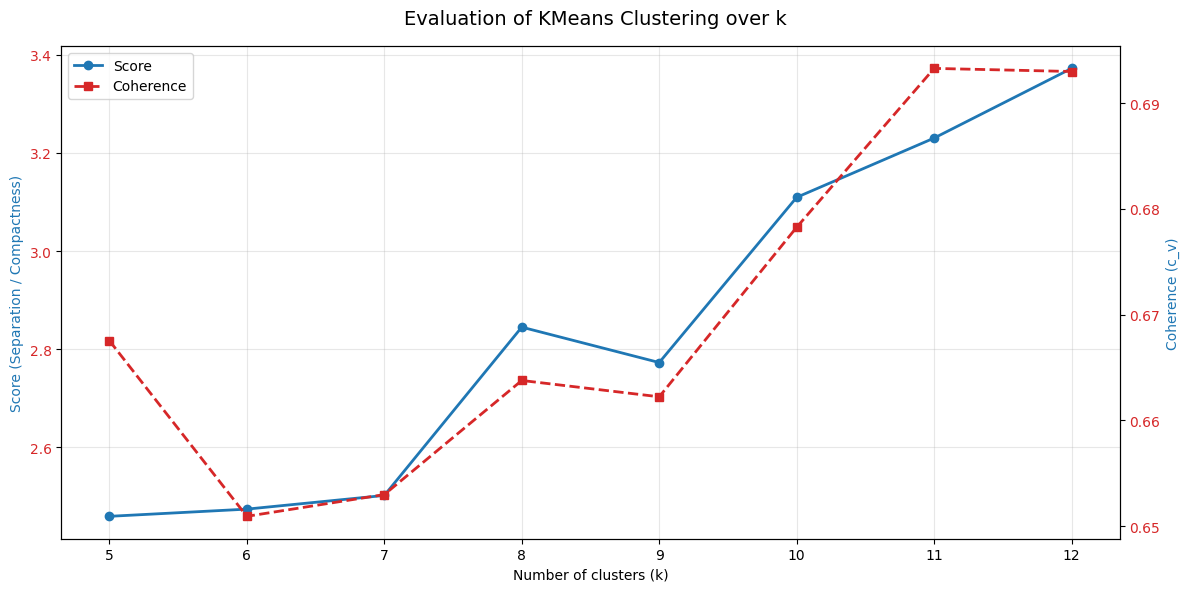

In [ ]:
def plot_score_coherence_dual_axis(results):
    ks = [r["k"] for r in results]
    scores = [r["score"] for r in results]
    coherences = [r["coherence"] for r in results]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # ===== Trục trái: SCORE =====
    ax1.set_xlabel("Number of clusters (k)")
    ax1.set_ylabel("Score (Separation / Compactness)", color="tab:blue")
    ax1.plot(
        ks, scores,
        marker="o",
        linewidth=2,
        color="tab:blue",
        label="Score"
    )
    ax1.tick_params(axis="y", labelcolor="tab:red")
    ax1.grid(True, alpha=0.3)

    # ===== Trục phải: COHERENCE =====
    ax2 = ax1.twinx()
    ax2.set_ylabel("Coherence (c_v)", color="tab:blue")
    ax2.plot(
        ks, coherences,
        marker="s",
        linewidth=2,
        linestyle="--",
        color="tab:red",
        label="Coherence"
    )
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # ===== Title & Legend =====
    fig.suptitle("Evaluation of KMeans Clustering over k", fontsize=14)

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

    plt.tight_layout()
    plt.show()

plot_score_coherence_dual_axis(results)


In [ ]:
    # ===== KMeans clustering =====
    kmeans_final = KMeans(
        n_clusters=12,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    # Corrected typo: Changed 'final_kmeans' to 'kmeans_final' to ensure the model is fitted.
    labels = kmeans_final.fit_predict(latent_vectors)

In [ ]:

def print_top_words_from_clusters(
    X_tfidf,
    labels,
    feature_names,
    topn=10
):
    """
    X_tfidf      : TF-IDF matrix (n_docs x n_terms)
    labels       : cluster labels (từ KMeans trên latent vectors)
    feature_names: tfidf.get_feature_names_out()
    topn         : số từ top
    """

    for k in np.unique(labels):
        # Lấy các document thuộc cluster k
        cluster_docs = X_tfidf[labels == k]

        # Tính TF-IDF trung bình
        mean_tfidf = cluster_docs.mean(axis=0)

        # Nếu là sparse matrix → chuyển sang array
        if hasattr(mean_tfidf, "A1"):
            mean_tfidf = mean_tfidf.A1

        # Lấy top-n từ
        top_indices = mean_tfidf.argsort()[-topn:][::-1]

        print(f"\nCluster {k}:")
        for idx in top_indices:
            print(f"  {feature_names[idx]:<25} {mean_tfidf[idx]:.4f}")

feature_names = tfidf.get_feature_names_out()

print_top_words_from_clusters(
    X_tfidf=X_tfidf,     # TF-IDF của document
    labels=labels,       # labels từ KMeans(latent_vectors)
    feature_names=feature_names,
    topn=10
)


Cluster 0:
  trận                      0.1106
  đấu                       0.0875
  việt_nam                  0.0751
  đội                       0.0727
  giải                      0.0678
  giành                     0.0542
  malaysia                  0.0541
  thi_đấu                   0.0531
  cầu_thủ                   0.0524
  vô_địch                   0.0505

Cluster 1:
  công_chức                 0.1314
  xã                        0.1140
  cán_bộ                    0.1116
  địa_phương                0.1104
  hành_chính                0.0854
  sắp_xếp                   0.0810
  cán_bộ công_chức          0.0788
  nội_vụ                    0.0753
  tỉnh                      0.0736
  chính_quyền               0.0704

Cluster 2:
  công_an                   0.0582
  đồng                      0.0441
  điều_tra                  0.0391
  bị_cáo                    0.0319
  cảnh_sát                  0.0312
  tiền                      0.0306
  vàng                      0.0288
  công_ty          

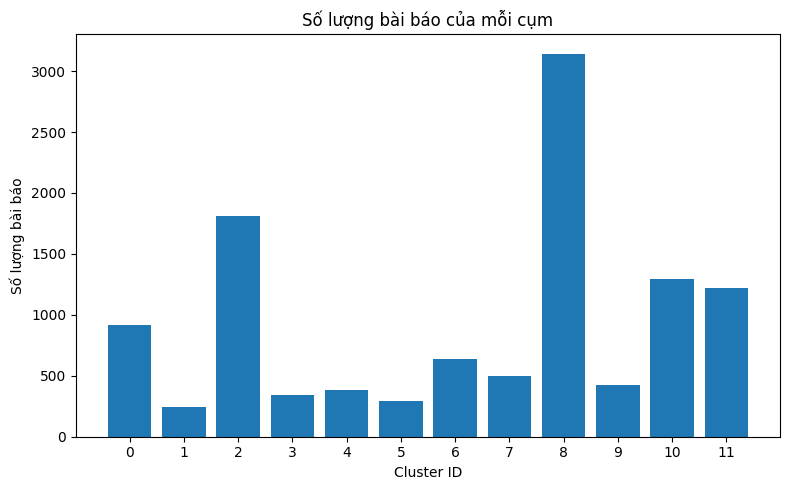

In [ ]:
    cluster_counts = Counter(labels)
    clusters = sorted(cluster_counts.keys())
    counts = [cluster_counts[k] for k in clusters]

    plt.figure(figsize=(8, 5))
    plt.bar(clusters, counts)
    plt.xlabel("Cluster ID")
    plt.ylabel("Số lượng bài báo")
    plt.title("Số lượng bài báo của mỗi cụm")
    plt.xticks(clusters)
    plt.tight_layout()
    plt.show()



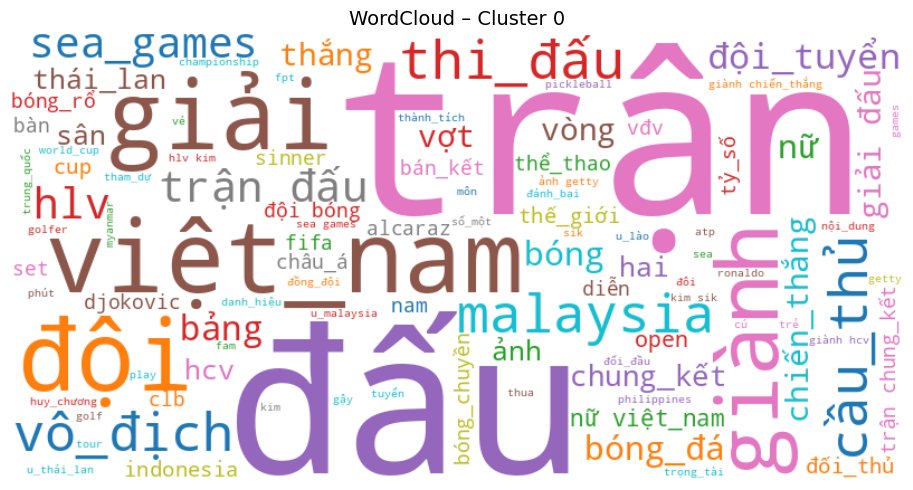

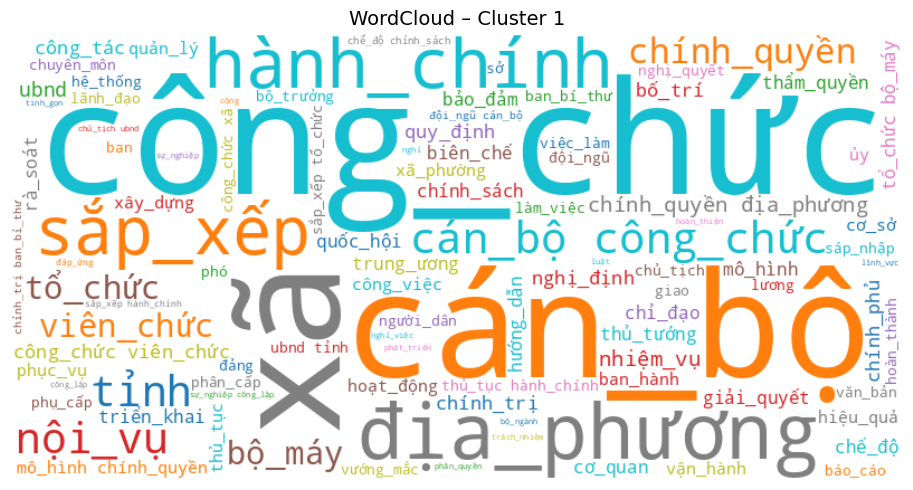

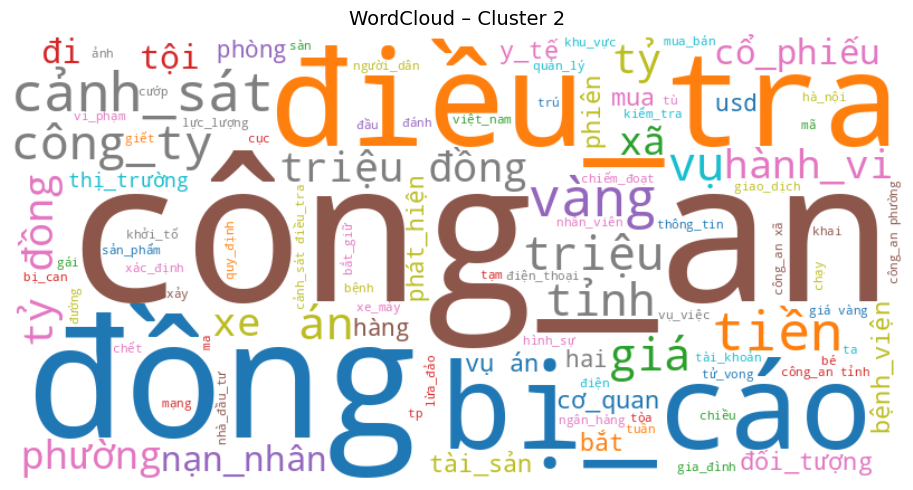

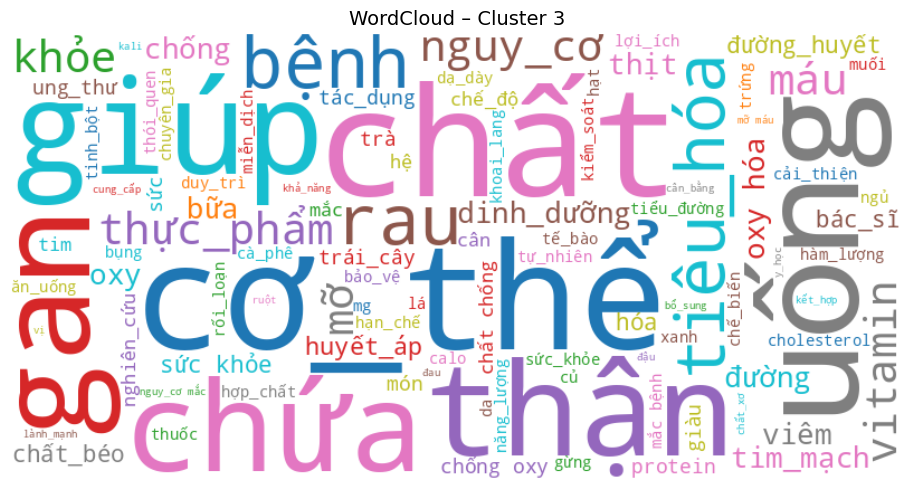

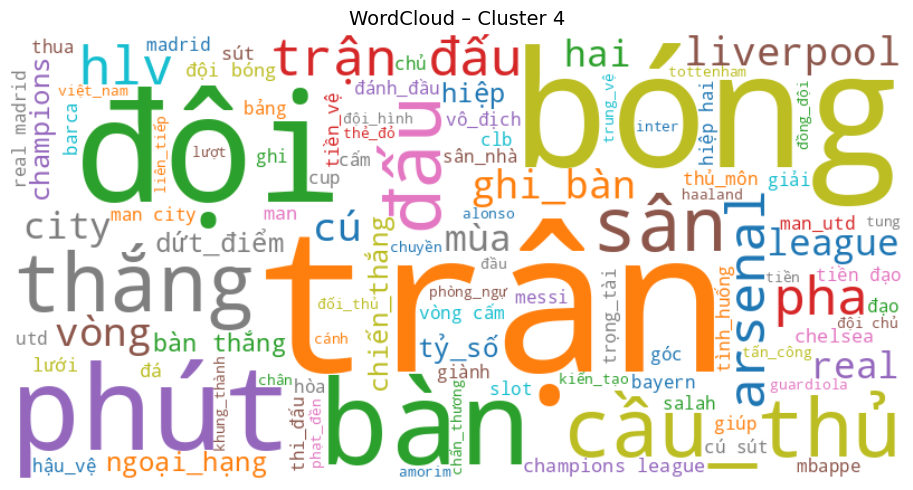

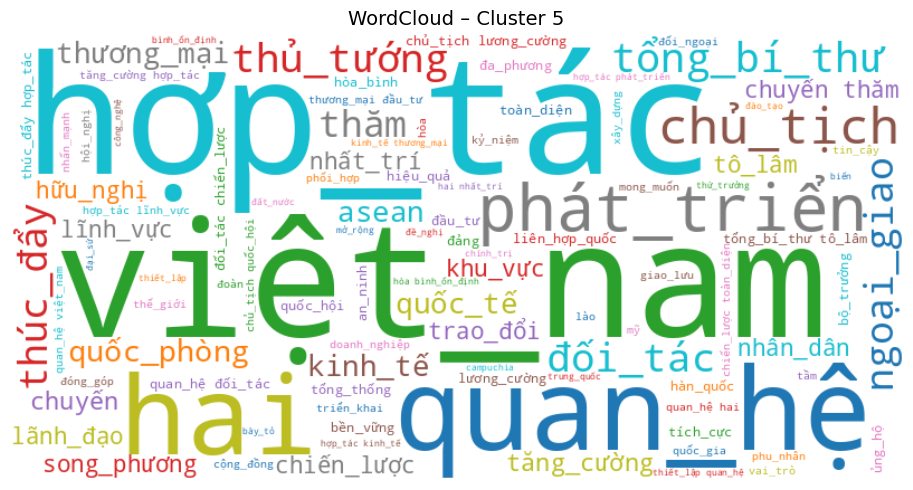

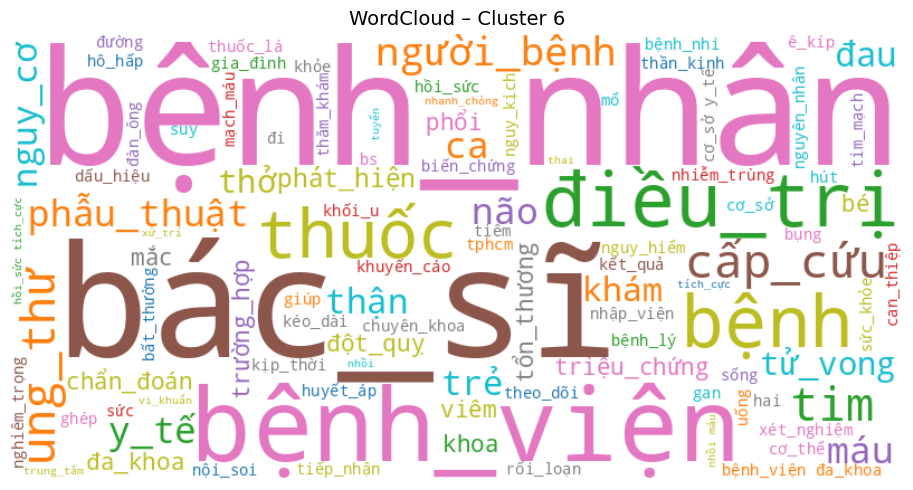

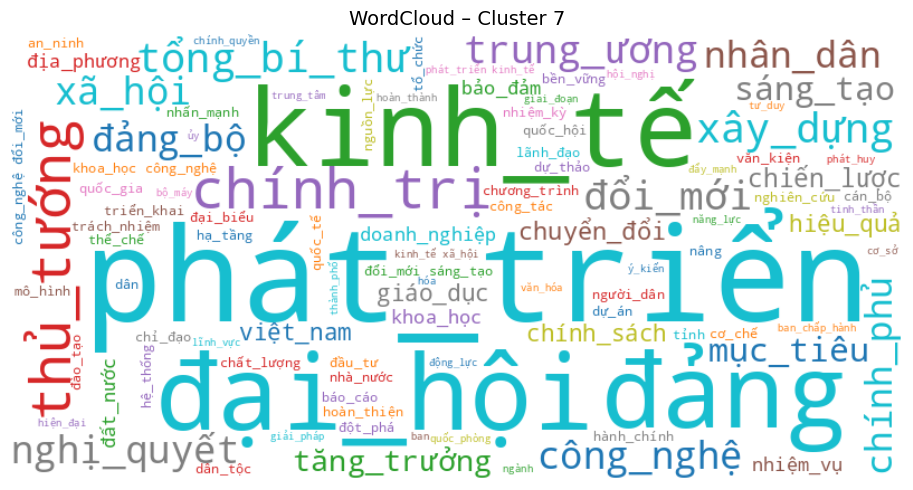

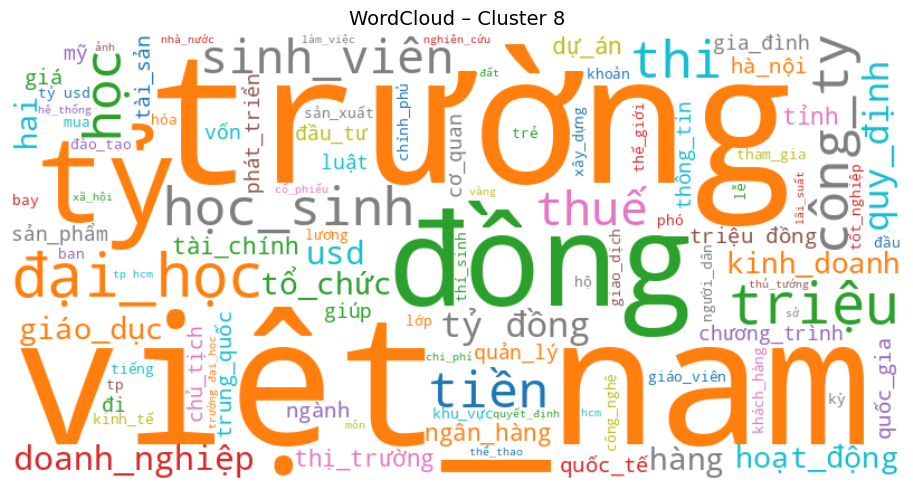

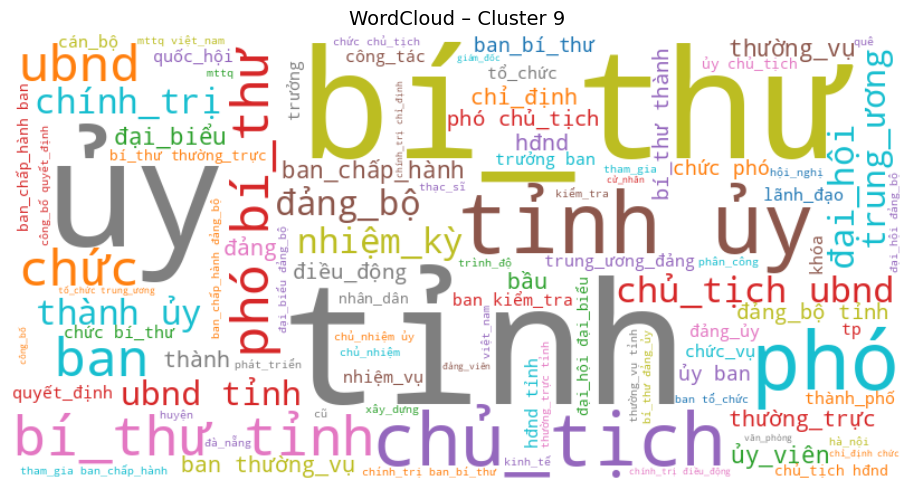

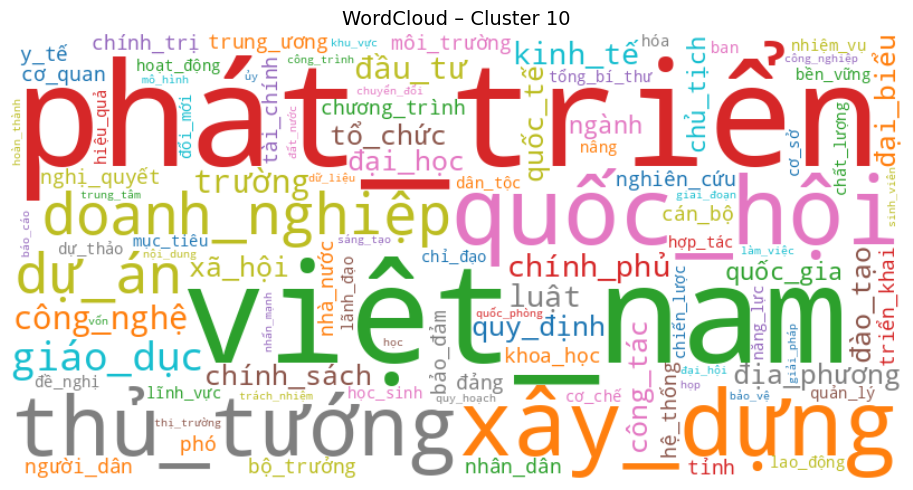

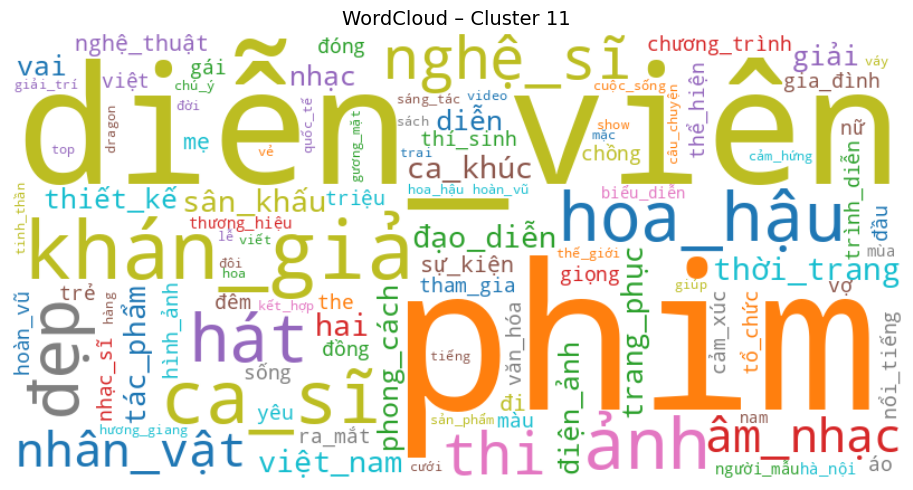

In [ ]:
# Duyệt từng cluster
for k in np.unique(labels):

    # ===== Lấy các document thuộc cluster k =====
    cluster_docs = X_tfidf[labels == k]

    # ===== TF-IDF trung bình =====
    mean_tfidf = cluster_docs.mean(axis=0)

    # Nếu là sparse matrix → chuyển sang array
    if hasattr(mean_tfidf, "A1"):
        mean_tfidf = mean_tfidf.A1

    # ===== Tạo dict word -> weight =====
    word_freq = {
        feature_names[i]: mean_tfidf[i]
        for i in np.argsort(mean_tfidf)[-100:]  # top 100 từ
        if mean_tfidf[i] > 0
    }

    # ===== Vẽ WordCloud =====
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        colormap="tab10"
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud – Cluster {k}", fontsize=14)
    plt.tight_layout()
    plt.show()
